# Context

## Brief

A partir d'une enquête de satisfaction menée sur un ensemble de 130 000 passagers, vous devez mettre en oeuvre une démarche de machine learning : 
- pour comprendre quelles sont les informations qui influent sur la satisfaction / insatisfaction d'un passager
- pour prédire la satisfaction / insatisfaction d'un passager

## Dictionnaire des données

- **Satisfaction** : *Airline satisfaction level(Satisfaction, neutral or dissatisfaction)*
- **Age** : *The actual age of the passengers*
- **Gender** : *Gender of the passengers (Female, Male)*
- **Type of Travel** : *Purpose of the flight of the passengers (Personal Travel, Business Travel)*
- **Class** : *Travel class in the plane of the passengers (Business, Eco, Eco Plus)*
- **Customer Type** : *The customer type (Loyal customer, disloyal customer)*
- **Flight distance** : *The flight distance of this journey*
- **Inflight wifi service** : *Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)*
- **Ease of Online booking** : *Satisfaction level of online booking*
- **Inflight service** : *Satisfaction level of inflight service*
- **Online boarding** : *Satisfaction level of online boarding*
- **Inflight entertainment** : *Satisfaction level of inflight entertainment*
- **Food and drink** : *Satisfaction level of Food and drink*
- **Seat comfort** : *Satisfaction level of Seat comfort*
- **On-board service** : *Satisfaction level of On-board service*
- **Leg room service** : *Satisfaction level of Leg room service*
- **Departure/Arrival time convenient** : *Satisfaction level of Departure/Arrival time convenient*
- **Baggage handling** : *Satisfaction level of baggage handling*
- **Gate location** : *Satisfaction level of Gate location*
- **Cleanliness** : *Satisfaction level of Cleanliness*
- **Check-in service** : *Satisfaction level of Check-in service*
- **Departure Delay in Minutes** : *Minutes delayed when departure*
- **Arrival Delay in Minutes** : *Minutes delayed when Arrival*
- **Flight cancelled** : *Whether the Flight cancelled or not (Yes, No)*
- **Flight time in minutes** : *Minutes of Flight takes*

# Imports et récupération des données

In [33]:
# Default
import pandas as pd
import seaborn as sns
import numpy as np
import ipywidgets as widgets
import warnings
import plotly.express as px
import time

# Anova et chi2
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

# machine learning - scikit learn:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.model_selection import GridSearchCV

# désactiver temporairement les avertissements
warnings.filterwarnings('ignore')

In [2]:
file_path = "https://raw.githubusercontent.com/remijul/dataset/master/Airline%20Passenger%20Satisfaction.csv"
df = pd.read_csv(file_path, sep=";", index_col=False)
df = df.drop('id', axis=1)

## Déclaration des fonctions

In [3]:
def correlation(dataframe, method):
  liste = []
  corr = dataframe.corr(method = method)
  colonnesIndex = corr.index
  colonnesNoms = corr.columns
  for colonne in colonnesIndex:
    for colonne2 in colonnesNoms:
      if colonne != colonne2:
        trie = [colonne, colonne2]
        trie.sort()
        liste.append([trie[0], trie[1], corr.loc[colonne, colonne2]])
  return pd.DataFrame(liste, columns=["col1", "col2", "values"]).drop_duplicates(["col1", "col2"])

In [4]:
def tauxDeRemplissage(df):
  return (df.notna().sum()*100/len(df)).sort_values()

# Exploration des données - EDA (Exploratory Data Analysis)

## Dataframe de base

In [5]:
df

,Satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,disloyal Customer,29,Personal Travel,Eco,1731,5,5,5,...,2,2,3,3,4,4,4,2,0,0.0
129876,neutral or dissatisfied,Male,disloyal Customer,63,Personal Travel,Business,2087,2,3,2,...,1,3,2,3,3,1,2,1,174,172.0
129877,neutral or dissatisfied,Male,disloyal Customer,69,Personal Travel,Eco,2320,3,0,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,neutral or dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0


## Aspect technique du dataframe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type of Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight Distance                    129880 non-null  int64  
 7   Seat comfort                       129880 non-null  int64  
 8   Departure/Arrival time convenient  129880 non-null  int64  
 9   Food and drink                     129880 non-null  int64  
 10  Gate location                      129880 non-null  int64  
 11  Inflight wifi service              1298

In [7]:
df.nunique()

Satisfaction                            2
Gender                                  2
Customer Type                           2
Age                                    75
Type of Travel                          2
Class                                   3
Flight Distance                      5398
Seat comfort                            6
Departure/Arrival time convenient       6
Food and drink                          6
Gate location                           6
Inflight wifi service                   6
Inflight entertainment                  6
Online support                          6
Ease of Online booking                  6
On-board service                        6
Leg room service                        6
Baggage handling                        5
Checkin service                         6
Cleanliness                             6
Online boarding                         6
Departure Delay in Minutes            466
Arrival Delay in Minutes              472
dtype: int64

In [8]:
df.describe()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1981.409055,2.838597,2.990645,2.851994,2.990422,3.249130,3.383477,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713,15.091129
std,15.119360,1027.115606,1.392983,1.527224,1.443729,1.305970,1.318818,1.346059,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126,38.465650
min,7.000000,50.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,1359.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,1925.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000
75%,51.000000,2544.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,6951.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [9]:
tauxDeRemplissage(df)

Arrival Delay in Minutes              99.697413
Online boarding                      100.000000
Cleanliness                          100.000000
Checkin service                      100.000000
Baggage handling                     100.000000
Leg room service                     100.000000
On-board service                     100.000000
Ease of Online booking               100.000000
Online support                       100.000000
Inflight entertainment               100.000000
Departure Delay in Minutes           100.000000
Satisfaction                         100.000000
Food and drink                       100.000000
Departure/Arrival time convenient    100.000000
Seat comfort                         100.000000
Flight Distance                      100.000000
Class                                100.000000
Type of Travel                       100.000000
Age                                  100.000000
Customer Type                        100.000000
Gender                               100

## Aspect relationnel des données

### Préparation d'un dataframe pour les corrélations

In [10]:
df_pour_correlation = df.copy()

colonnes_num = list(df_pour_correlation.select_dtypes(include=['int', 'float']).columns)
colonnes_cat = list(df_pour_correlation.select_dtypes(include=['object']).columns)

print(f'Colonnes numériques : {colonnes_num}')
print(f'Colonnes catégorielles : {colonnes_cat}')

print(f'\nPossibilités dans les colonnes catégorielles : \n')
for nom_colonne in colonnes_cat:
    print(f'{nom_colonne} : {df_pour_correlation[nom_colonne].unique()}')
    print('-------------------')

Colonnes numériques : ['Age', 'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Colonnes catégorielles : ['Satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class']

Possibilités dans les colonnes catégorielles : 

Satisfaction : ['satisfied' 'neutral or dissatisfied']
-------------------
Gender : ['Female' 'Male']
-------------------
Customer Type : ['Loyal Customer' 'disloyal Customer']
-------------------
Type of Travel : ['Personal Travel' 'Business travel']
-------------------
Class : ['Eco' 'Business' 'Eco Plus']
-------------------


In [11]:

df_pour_correlation['Gender'] = df_pour_correlation['Gender'].replace({'Female': 1, 'Male': 0})
df_pour_correlation['Satisfaction'] = df_pour_correlation['Satisfaction'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})
df_pour_correlation['Customer Type'] = df_pour_correlation['Customer Type'].replace({'Loyal Customer': 1, 'disloyal Customer': 0})
df_pour_correlation['Type of Travel'] = df_pour_correlation['Type of Travel'].replace({'Personal Travel': 1, 'Business travel': 0})
df_pour_correlation['Class'] = df_pour_correlation['Class'].replace({'Business': 2, 'Eco Plus': 1, 'Eco': 0})
df_pour_correlation


,Satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,1,1,1,65,1,0,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,1,0,1,47,1,2,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,1,1,1,15,1,0,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,1,1,1,60,1,0,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,1,1,1,70,1,0,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1,1,0,29,1,0,1731,5,5,5,...,2,2,3,3,4,4,4,2,0,0.0
129876,0,0,0,63,1,2,2087,2,3,2,...,1,3,2,3,3,1,2,1,174,172.0
129877,0,0,0,69,1,0,2320,3,0,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,0,0,0,66,1,0,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0


### Matrices de corrélations

<Axes: >

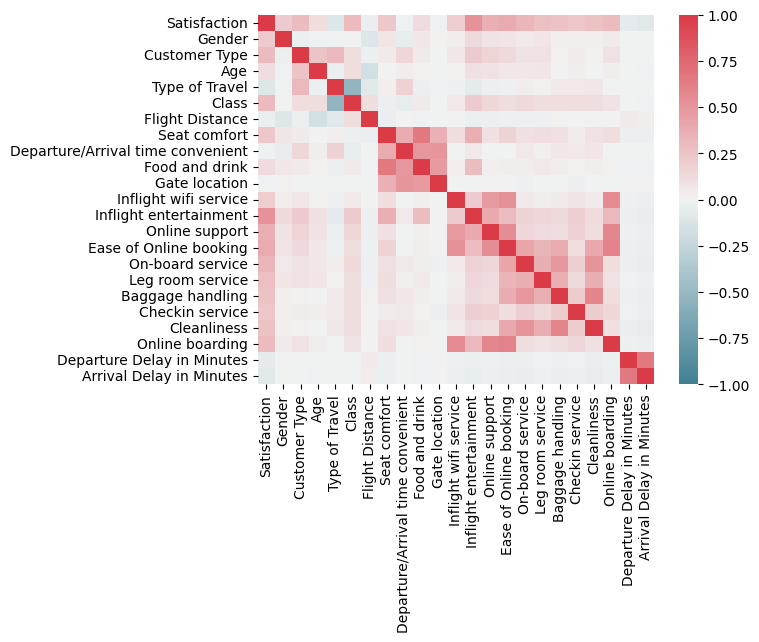

In [12]:
corr_matrix = df_pour_correlation.corr(method='kendall')
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, cmap=cmap, vmin=-1, vmax=1)

Etude de la heatmap :
- forte relation entre le retard à l'arrivée et le retard au départ => normal je dirais !
- forte relation entre la qualité de la nourriture et la qualité de la place => explique probablement la différence des classes

In [13]:
corr_matrix_2by2 = correlation(df_pour_correlation, "kendall")
corr_matrix_2by2 = corr_matrix_2by2.sort_values('values', ascending=False)

Variables qui ont une forte correlation :

In [14]:
df_style = corr_matrix_2by2.loc[corr_matrix_2by2['values'] > 0.5].style
display(df_style)

,col1,col2,values
483,Arrival Delay in Minutes,Departure Delay in Minutes,0.657873
162,Food and drink,Seat comfort,0.655096
327,Ease of Online booking,Online boarding,0.601894
392,Baggage handling,Cleanliness,0.586595
305,Online boarding,Online support,0.585014
261,Inflight wifi service,Online boarding,0.559782
299,Ease of Online booking,Online support,0.543543
255,Ease of Online booking,Inflight wifi service,0.524836
11,Inflight entertainment,Satisfaction,0.519570
348,Cleanliness,On-board service,0.514360


Variables qui ont une forte correlation inverse :

In [15]:
df_style = corr_matrix_2by2.loc[corr_matrix_2by2['values'] < -0.1].style
display(df_style)

,col1,col2,values
27,Flight Distance,Gender,-0.101623
3,Satisfaction,Type of Travel,-0.109239
71,Age,Flight Distance,-0.165961
92,Class,Type of Travel,-0.530874


Variables qui n'ont pas de correlation : 

In [16]:
df_style = corr_matrix_2by2.loc[(corr_matrix_2by2['values'] < 0.1) & (corr_matrix_2by2['values'] > -0.1)].style
#display(df_style)

Correlations avec la satisfaction : 

In [17]:
df_style = corr_matrix_2by2.loc[(corr_matrix_2by2['col1'] == 'Satisfaction') | (corr_matrix_2by2['col2'] == 'Satisfaction')].style
display(df_style)

,col1,col2,values
11,Inflight entertainment,Satisfaction,0.519570
13,Ease of Online booking,Satisfaction,0.387335
12,Online support,Satisfaction,0.363629
14,On-board service,Satisfaction,0.322337
19,Online boarding,Satisfaction,0.299704
4,Class,Satisfaction,0.297445
1,Customer Type,Satisfaction,0.292592
15,Leg room service,Satisfaction,0.278201
16,Baggage handling,Satisfaction,0.262040
18,Cleanliness,Satisfaction,0.259264


### Test anova

In [18]:
df_anova = df.copy()
df_anova.columns = ['Satisfaction',	'Gender', 'Customer_Type', 'Age', 'Type_of_Travel',
                    'Class', 'Flight_Distance', 'Seat_comfort', 'Departure_Arrival_time_convenient', 
                    'Food_and_drink', 'Gate_location', 'Inflight_wifi_service', 'Inflight_entertainment', 'Online_support', 
                    'Ease_of_Online_booking', 'On_board_service', 'Leg_room_service', 'Baggage_handling',
                    'Checkin_service', 'Cleanliness', 'Online_boarding', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']
df_anova['Satisfaction'] = df_anova['Satisfaction'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})
df_anova

,Satisfaction,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,...,Online_support,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
0,1,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,1,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,1,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,1,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,1,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,1,Female,disloyal Customer,29,Personal Travel,Eco,1731,5,5,5,...,2,2,3,3,4,4,4,2,0,0.0
129876,0,Male,disloyal Customer,63,Personal Travel,Business,2087,2,3,2,...,1,3,2,3,3,1,2,1,174,172.0
129877,0,Male,disloyal Customer,69,Personal Travel,Eco,2320,3,0,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,0,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0


In [19]:
#Gender + Customer_Type + Age + Type_of_Travel + Class + Flight_Distance + Seat_comfort + Departure_Arrival_time_convenient + 
#Food_and_drink + Gate_location + Inflight_wifi_service + Inflight_entertainment + Online_support + Ease_of_Online_booking + 
#On_board_service + Leg_room_service + Baggage_handling + Checkin_service + Cleanliness + Online_boarding + Departure_Delay_in_Minutes + Arrival_Delay_in_Minutes'

model = ols('Satisfaction ~ Gender + Customer_Type + Age + Type_of_Travel + Class + Flight_Distance + Seat_comfort + Departure_Arrival_time_convenient + Food_and_drink + Gate_location + Inflight_wifi_service + Inflight_entertainment + Online_support + Ease_of_Online_booking + On_board_service + Leg_room_service + Baggage_handling + Checkin_service + Cleanliness + Online_boarding + Departure_Delay_in_Minutes + Arrival_Delay_in_Minutes', data=df_anova)
entrainement = model.fit()
anova_lm(entrainement)

#rien compris

,df,sum_sq,mean_sq,F,PR(>F)
Gender,1.0,1442.520571,1442.520571,11290.529318,0.000000e+00
Customer_Type,1.0,2872.588476,2872.588476,22483.592295,0.000000e+00
Type_of_Travel,1.0,1405.791222,1405.791222,11003.050715,0.000000e+00
Class,2.0,1339.639443,669.819721,5242.642185,0.000000e+00
Age,1.0,0.169993,0.169993,1.330524,2.487142e-01
Flight_Distance,1.0,117.437766,117.437766,919.178945,3.383450e-201
Seat_comfort,1.0,1590.744659,1590.744659,12450.671114,0.000000e+00
Departure_Arrival_time_convenient,1.0,704.072128,704.072128,5510.733893,0.000000e+00
Food_and_drink,1.0,145.686094,145.686094,1140.277057,7.096017e-249
Gate_location,1.0,43.357530,43.357530,339.357009,1.101243e-75


### Test chi2

In [20]:
chi2 = df.copy()
chi2

,Satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129875,satisfied,Female,disloyal Customer,29,Personal Travel,Eco,1731,5,5,5,...,2,2,3,3,4,4,4,2,0,0.0
129876,neutral or dissatisfied,Male,disloyal Customer,63,Personal Travel,Business,2087,2,3,2,...,1,3,2,3,3,1,2,1,174,172.0
129877,neutral or dissatisfied,Male,disloyal Customer,69,Personal Travel,Eco,2320,3,0,3,...,2,4,4,3,4,2,3,2,155,163.0
129878,neutral or dissatisfied,Male,disloyal Customer,66,Personal Travel,Eco,2450,3,2,3,...,2,3,3,2,3,2,1,2,193,205.0


In [21]:
#chi2.groupby(by=["Satisfaction", "Class"]).count()

st_chi2, st_p, st_dof, st_exp  = chi2_contingency(chi2[["Satisfaction", "Class"]].pivot_table(index="Satisfaction", columns="Class", aggfunc=len))

if st_p > 0.05:
  print("La satisfaction ou non n'a rien à voir avec la classe")
elif st_p < 0.05:
  print("La classe a un lien avec la satisfaction")

print(f"La p-value vaut {st_p}")

La classe a un lien avec la satisfaction
La p-value vaut 0.0


In [22]:
#chi2.groupby(by=["Satisfaction", "Gender"]).count()

st_chi2, st_p, st_dof, st_exp  = chi2_contingency(chi2[["Satisfaction", "Gender"]].pivot_table(index="Satisfaction", columns="Gender", aggfunc=len))

if st_p > 0.05:
  print("La satisfaction ou non n'a rien à voir avec le genre")
elif st_p < 0.05:
  print("Le genre a un lien avec la satisfaction")

print(f"La p-value vaut {st_p}")

Le genre a un lien avec la satisfaction
La p-value vaut 0.0


In [23]:
#chi2.groupby(by=["Satisfaction", "Customer Type"]).count()

st_chi2, st_p, st_dof, st_exp  = chi2_contingency(chi2[["Satisfaction", "Customer Type"]].pivot_table(index="Satisfaction", columns="Customer Type", aggfunc=len))

if st_p > 0.05:
  print("La satisfaction ou non n'a rien à voir avec le Customer Type")
elif st_p < 0.05:
  print("Le Customer Type a un lien avec la satisfaction")

print(f"La p-value vaut {st_p}")

Le Customer Type a un lien avec la satisfaction
La p-value vaut 0.0


## Graphs

In [24]:
df_graph = df.copy()

df_graph.columns = ['Satisfaction',	'Gender', 'Customer_Type', 'Age', 'Type_of_Travel',
                    'Class', 'Flight_Distance', 'Seat_comfort', 'Departure_Arrival_time_convenient', 
                    'Food_and_drink', 'Gate_location', 'Inflight_wifi_service', 'Inflight_entertainment', 'Online_support', 
                    'Ease_of_Online_booking', 'On_board_service', 'Leg_room_service', 'Baggage_handling',
                    'Checkin_service', 'Cleanliness', 'Online_boarding', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']

colonnes_num = list(df_graph.select_dtypes(include=['int', 'float']).columns)
colonnes_cat = list(df_graph.select_dtypes(include=['object']).columns)

print(f'Colonnes numériques : {colonnes_num}')
print(f'Colonnes catégorielles : {colonnes_cat}')

df_graph['Satisfaction'] = df_graph['Satisfaction'].replace({'satisfied': 1, 'neutral or dissatisfied': 0})
# df_graph['Gender'] = df_graph['Gender'].replace({'Female': 1, 'Male': 0})
# df_graph['Customer_Type'] = df_graph['Customer_Type'].replace({'Loyal Customer': 1, 'disloyal Customer': 0})
# df_graph['Type_of_Travel'] = df_graph['Type_of_Travel'].replace({'Personal Travel': 1, 'Business travel': 0})
# df_graph['Class'] = df_graph['Class'].replace({'Business': 2, 'Eco Plus': 1, 'Eco': 0})



Colonnes numériques : ['Age', 'Flight_Distance', 'Seat_comfort', 'Departure_Arrival_time_convenient', 'Food_and_drink', 'Gate_location', 'Inflight_wifi_service', 'Inflight_entertainment', 'Online_support', 'Ease_of_Online_booking', 'On_board_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']
Colonnes catégorielles : ['Satisfaction', 'Gender', 'Customer_Type', 'Type_of_Travel', 'Class']


In [25]:
df_graph_bar = df_graph.loc[:, ['Satisfaction', 'Inflight_entertainment', 'Class']]
print (df_graph_bar)
#fig = px.bar(df_graph_bar, x="Satisfaction", y="Inflight_entertainment", color="Class", title="Long-Form Input")
#fig.show()

        Satisfaction  Inflight_entertainment     Class
0                  1                       4       Eco
1                  1                       2  Business
2                  1                       0       Eco
3                  1                       4       Eco
4                  1                       3       Eco
...              ...                     ...       ...
129875             1                       5       Eco
129876             0                       1  Business
129877             0                       2       Eco
129878             0                       2       Eco
129879             0                       3       Eco

[129880 rows x 3 columns]


# Modélisation

## Définition de notre X(données) et y(target)

In [26]:
df_pour_modelisation = df_graph.copy()
df_pour_modelisation = df_pour_modelisation.dropna()

print(f'Colonnes numériques : {colonnes_num}')
print(f'Colonnes catégorielles : {colonnes_cat}')

Colonnes numériques : ['Age', 'Flight_Distance', 'Seat_comfort', 'Departure_Arrival_time_convenient', 'Food_and_drink', 'Gate_location', 'Inflight_wifi_service', 'Inflight_entertainment', 'Online_support', 'Ease_of_Online_booking', 'On_board_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding', 'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes']
Colonnes catégorielles : ['Satisfaction', 'Gender', 'Customer_Type', 'Type_of_Travel', 'Class']


In [44]:
y = df_pour_modelisation['Satisfaction']
X = df_pour_modelisation.drop(['Satisfaction'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

print("La longueur du dataset de base :", len(X))
print("La longueur du dataset d'entraînement :", len(X_train))
print("La longueur du dataset de test :", len(X_test))

La longueur du dataset de base : 129487
La longueur du dataset d'entraînement : 90640
La longueur du dataset de test : 38847


## Création de l'étape preparation du pipeline

In [45]:

preparation = ColumnTransformer(
    transformers=[       
        ('data_cat',
         OneHotEncoder(handle_unknown='ignore'), ['Gender', 'Customer_Type', 'Type_of_Travel', 'Class']),
        ('data_num',
         StandardScaler(),colonnes_num),         
    ])

#Création du pipeline
model_lm = Pipeline([('scaler', preparation),
                        ('classifier',RandomForestRegressor())])

## Entraînement du modèle

In [43]:
#Entraînement du modèle
model_lm.fit(X_train, y_train)

y_pred = model_lm.predict(X_test)

print(f"La moyenne : {y_pred.mean()}")
print(f"La médiane : {np.median(y_pred)}")

print(f"r2_score : {r2_score(y_test, y_pred)*100:.2f}%")

La moyenne : 0.5512155378793729
La médiane : 0.79
r2_score : 87.43%


## Test de plusieurs modèles

In [52]:
# Définition des paramètres à ajuster
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(),
    'SVC': SVC(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'RandomForestRegressor': RandomForestRegressor(),
    'SVR': SVR(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'LinearRegression': LinearRegression(),
}

params = {
    'LogisticRegression': {'C': [0.1, 1, 10]},
    'RandomForestClassifier': {'max_depth': [10, 50, 100]},
    'SVC': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]},
    'GradientBoostingRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.1, 0.5, 1.0], 'max_depth': [1, 3, 5]},
    'RandomForestRegressor': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20],},
    'SVR': {'kernel':['linear','rbf'], 'C':[0.1,1,10]},
    'Lasso': {'alpha':[0.1, 1, 10]},
    'Ridge': {'alpha':[0.1, 1, 10]},
    'LinearRegression': {},
}



In [53]:
X_train_prepared = preparation.fit_transform(X_train)
X_test_prepared = preparation.transform(X_test)


p=0
for model_name, model in models.items():
    p=p+1
    print(f"\n-----------------------------Modèle {p}---------------------------------\n")
    print(f"GridSearchCV for {model_name}")
    
    start_time = time.time()

    gs = GridSearchCV(model, params[model_name], cv=5)
    gs.fit(X_train_prepared, y_train)

    end_time = time.time()
    training_time = end_time - start_time

    print(f"Best params: {gs.best_params_}")
    print(f"Train score: {gs.best_score_*100:.3f}%")
    print(f"Test score: {gs.score(X_test_prepared, y_test)*100:.3f}%\n")    
    print(f"\n------------------------------------------------------- {training_time:.2f} seconds")


-----------------------------Modèle 1---------------------------------

GridSearchCV for LogisticRegression
Best params: {'C': 1}
Train score: 83.460%
Test score: 83.801%


------------------------------------------------------- 5.88 seconds

-----------------------------Modèle 2---------------------------------

GridSearchCV for RandomForestClassifier
Best params: {'max_depth': 100}
Train score: 95.664%
Test score: 95.794%


------------------------------------------------------- 104.75 seconds

-----------------------------Modèle 3---------------------------------

GridSearchCV for SVC
